In [49]:
# DEFINING REQUIRED PACKAGES ---------------------------------------
import matplotlib.pyplot as plt #import matplotlib to create plots
import scipy.optimize as opt; #allows for curve fitting
from scipy.odr import *
import pandas as pd #importing pandas to use dataframes
import numpy as np
from scipy.constants import g, pi
plt.style.reload_library()
plt.style.use(['science', 'grid'])
from scipy.odr import ODR, Model, Data, RealData
from scipy.optimize import curve_fit
import ipywidgets as widgets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [50]:
# FITTING FUNCTIONS
def linearODR(B,x):
    return B[0]*x 

def LinearPlotODR(xdata,ydata,error_y,error_x,a,b,function,output,color,x_label,y_label):
    fig = plt.figure(figsize=(5, 5), dpi=80)
    plt.errorbar(xdata,ydata,yerr=error_y,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    plt.errorbar(xdata,ydata,xerr=error_x,capsize = 5,marker = 'o',markersize=4, linestyle = 'None',color='black')
    if b==0:
        label = r'$\textit{Y = ' + str("{:.2e}".format(a)) + 'X}$'
    else:
        label = r'$\textit{Y = ' + str("{:.2e}".format(a)) + 'X + ' + str("{:.2e}".format(b)) + '}$'
    plt.plot(xdata,function(output.beta, xdata),label = label, color=color)
    plt.legend(loc = 'upper left')
    plt.xlabel(r'$\textit{'+ x_label +'}$', fontsize = 16)
    plt.ylabel(r'$\textit{'+ y_label +'}$', fontsize = 16)
    #plt.xticks(np.arange(min(xdata), max(xdata), (max(xdata)-min(xdata))/5))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.legend(prop={'size': 12}, loc=2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("Figures/figure.png")

In [51]:
def D_prime(par):
    D,L,t,r = par[0], 0.13, 1.5*10**(-3), 6.6*10**(-2)
    return D*L/(L-t-r+np.sqrt(r**2-(D/2)**2))

def lambda_bragg(par): # par = [D', L, d]
    return par[0]*par[2]/(2*par[1])

from scipy.constants import e, m_e, h
def lambda_deBroglie(par): # par = [V]
    return (10**9)*h/np.sqrt(2*m_e*e*par[0]*1000)

# DEFINING A FUNCTION THAT RETURNS THE UNCERTAINTY USING VARIATIONAL METHOD (Each function must receive a parameters array)
def uncertainty_var(values, deltas, function):
    values, deltas = np.array(values), np.array(deltas)
    delta_matrix = deltas*np.identity(values.shape[0])
    sum = 0
    for delta in delta_matrix:
        sum += (0.5*(abs(function(values + delta) - function(values)) + abs(function(values-delta) - function(values))))**2
    return np.sqrt(sum)

In [52]:
# READING THE DATA FROM GOOGLE SHEETS ---------------------------------------
googleSheetId = '1aIw6aJ448unMb0DoGB0bVqn1nAi9RwDifkZH0FSNb88'
workSheetName = 'ForJupyter'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId, workSheetName)
df = pd.read_csv(URL)
df = df.iloc[: , :7]
df

,V (kV),Delta V (kV),D_avg1,D_avg2,D_avg3,D_avg4,Delta D
0,2.0,0.1,0.030610,0.031860,0.055560,0.057305,0.00005
1,2.5,0.1,0.027205,0.029850,0.049425,0.051820,0.00005
2,3.0,0.1,0.024045,0.026860,0.045230,0.046935,0.00005
3,3.5,0.1,0.022635,0.026015,0.042240,0.044050,0.00005
4,4.0,0.1,0.021065,0.023345,0.038135,0.040660,0.00005
5,4.5,0.1,0.019545,0.021755,0.037990,0.038770,0.00005
6,5.0,0.1,0.018845,0.020025,0.034290,0.036605,0.00005


In [53]:
# GENERATING DELTA PRIMES
df['D_prime1'] = df[['D_avg1']].apply(D_prime, axis=1)
df['D_prime2'] = df[['D_avg2']].apply(D_prime, axis=1)
df['D_prime3'] = df[['D_avg3']].apply(D_prime, axis=1)
df['D_prime4'] = df[['D_avg4']].apply(D_prime, axis=1)
df['Delta_prime1'] = df[['D_avg1','Delta D']].apply(lambda x: uncertainty_var([x[0]],[x[1]],D_prime),axis=1)
df['Delta_prime2'] = df[['D_avg2','Delta D']].apply(lambda x: uncertainty_var([x[0]],[x[1]],D_prime),axis=1)
df['Delta_prime3'] = df[['D_avg3','Delta D']].apply(lambda x: uncertainty_var([x[0]],[x[1]],D_prime),axis=1)
df['Delta_prime4'] = df[['D_avg4','Delta D']].apply(lambda x: uncertainty_var([x[0]],[x[1]],D_prime),axis=1)
df

# CALCULATING WAVELENGTHS USING DE BROGLIE EQUATION
df['$\lambda_{de Broglie} (nm)$'] = df[['V (kV)']].apply(lambda_deBroglie, axis=1)
df['$\Delta \lambda_{de Broglie} (nm)$'] = df[['V (kV)','Delta V (kV)']].apply(lambda x: uncertainty_var([x[0]],[x[1]],lambda_deBroglie),axis=1)

In [54]:
# CALCULATING WAVELENGTHS USING BRAGG CONDITION FOR: Smaller ring (Innermost edge)
L, L_error = 0.13, 0.002
d11, d10 = 0.123, 0.213
df['$\lambda_{Bragg} (nm)$'] = df[['D_avg1']].apply(lambda x: lambda_bragg([x[0],L,d10]),axis=1)
df['$\Delta \lambda_{Bragg} (nm)$'] = df[['D_prime1','Delta_prime1']].apply(lambda x: uncertainty_var([x[0],L,d10],[x[1],L_error,0],lambda_bragg),axis=1)
df

,V (kV),Delta V (kV),D_avg1,D_avg2,D_avg3,D_avg4,Delta D,D_prime1,D_prime2,D_prime3,D_prime4,Delta_prime1,Delta_prime2,Delta_prime3,Delta_prime4,$\lambda_{de Broglie} (nm)$,$\Delta \lambda_{de Broglie} (nm)$,$\lambda_{Bragg} (nm)$,$\Delta \lambda_{Bragg} (nm)$
0,2.0,0.1,0.030610,0.031860,0.055560,0.057305,0.00005,0.031407,0.032729,0.059025,0.061085,0.000053,0.000053,0.000059,0.000059,0.027424,0.000687,0.025077,0.000398
1,2.5,0.1,0.027205,0.029850,0.049425,0.051820,0.00005,0.027829,0.030606,0.051943,0.054680,0.000052,0.000053,0.000057,0.000057,0.024529,0.000491,0.022287,0.000353
2,3.0,0.1,0.024045,0.026860,0.045230,0.046935,0.00005,0.024537,0.027469,0.047226,0.049132,0.000052,0.000052,0.000056,0.000056,0.022391,0.000373,0.019698,0.000312
3,3.5,0.1,0.022635,0.026015,0.042240,0.044050,0.00005,0.023075,0.026587,0.043919,0.045916,0.000052,0.000052,0.000055,0.000055,0.020730,0.000296,0.018543,0.000294
4,4.0,0.1,0.021065,0.023345,0.038135,0.040660,0.00005,0.021452,0.023810,0.039444,0.042188,0.000052,0.000052,0.000054,0.000055,0.019391,0.000242,0.017257,0.000274
5,4.5,0.1,0.019545,0.021755,0.037990,0.038770,0.00005,0.019886,0.022165,0.039287,0.040132,0.000051,0.000052,0.000054,0.000054,0.018282,0.000203,0.016012,0.000254
6,5.0,0.1,0.018845,0.020025,0.034290,0.036605,0.00005,0.019166,0.020380,0.035313,0.037794,0.000051,0.000051,0.000053,0.000054,0.017344,0.000173,0.015438,0.000245


Slope =  0.8929198738952615  ±  0.005303668492565378
Error =  10.70801261047385 %


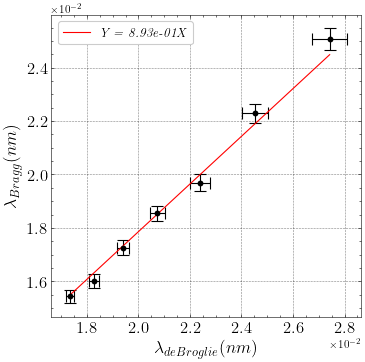

In [55]:
# FITTING THE DATA USING A LINEAR RELATIONSHIP ---------------------------------------
xdata, ydata = df['$\lambda_{de Broglie} (nm)$'], df['$\lambda_{Bragg} (nm)$']
error_x, error_y = df['$\Delta \lambda_{de Broglie} (nm)$'], df['$\Delta \lambda_{Bragg} (nm)$']
# LINEAR REGRESSION USSING UNCERTAINTY IN X AND Y
from scipy.odr import ODR, Model, Data, RealData
model = Model(linearODR)

data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0,0])
odr.set_job(fit_type=2)
output = odr.run()
a,b = output.beta[0], output.beta[1]

#Calculate the error on the fits from the std matrix
slope = output.beta[0]
slope_error = output.sd_beta[0]
LinearPlotODR(xdata,ydata,error_y,error_x,a,b,linearODR,output,'red','$\lambda_{de Broglie} (nm)$','$\lambda_{Bragg} (nm)$')
print('Slope = ', slope, ' ± ', slope_error)
error = abs(1-slope)*100
print('Error = ', error, '%')

In [56]:
# CALCULATING WAVELENGTHS USING BRAGG CONDITION FOR: Smaller ring (Middle)
df['$\lambda_{Bragg} (nm)$'] = df[['D_avg2']].apply(lambda x: lambda_bragg([x[0],L,d10]),axis=1)
df['$\Delta \lambda_{Bragg} (nm)$'] = df[['D_prime2','Delta_prime2']].apply(lambda x: uncertainty_var([x[0],L,d10],[x[1],L_error,0],lambda_bragg),axis=1)
df

,V (kV),Delta V (kV),D_avg1,D_avg2,D_avg3,D_avg4,Delta D,D_prime1,D_prime2,D_prime3,D_prime4,Delta_prime1,Delta_prime2,Delta_prime3,Delta_prime4,$\lambda_{de Broglie} (nm)$,$\Delta \lambda_{de Broglie} (nm)$,$\lambda_{Bragg} (nm)$,$\Delta \lambda_{Bragg} (nm)$
0,2.0,0.1,0.030610,0.031860,0.055560,0.057305,0.00005,0.031407,0.032729,0.059025,0.061085,0.000053,0.000053,0.000059,0.000059,0.027424,0.000687,0.026101,0.000415
1,2.5,0.1,0.027205,0.029850,0.049425,0.051820,0.00005,0.027829,0.030606,0.051943,0.054680,0.000052,0.000053,0.000057,0.000057,0.024529,0.000491,0.024454,0.000388
2,3.0,0.1,0.024045,0.026860,0.045230,0.046935,0.00005,0.024537,0.027469,0.047226,0.049132,0.000052,0.000052,0.000056,0.000056,0.022391,0.000373,0.022005,0.000349
3,3.5,0.1,0.022635,0.026015,0.042240,0.044050,0.00005,0.023075,0.026587,0.043919,0.045916,0.000052,0.000052,0.000055,0.000055,0.020730,0.000296,0.021312,0.000338
4,4.0,0.1,0.021065,0.023345,0.038135,0.040660,0.00005,0.021452,0.023810,0.039444,0.042188,0.000052,0.000052,0.000054,0.000055,0.019391,0.000242,0.019125,0.000303
5,4.5,0.1,0.019545,0.021755,0.037990,0.038770,0.00005,0.019886,0.022165,0.039287,0.040132,0.000051,0.000052,0.000054,0.000054,0.018282,0.000203,0.017822,0.000283
6,5.0,0.1,0.018845,0.020025,0.034290,0.036605,0.00005,0.019166,0.020380,0.035313,0.037794,0.000051,0.000051,0.000053,0.000054,0.017344,0.000173,0.016405,0.000260


Slope =  0.9796166072525114  ±  0.010403737057710397
Error =  2.038339274748857 %


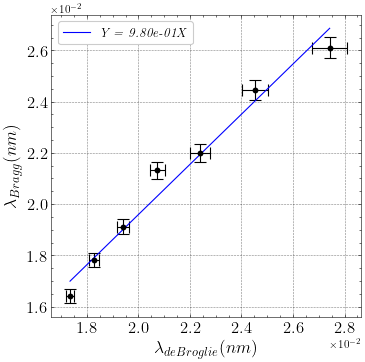

In [57]:
# FITTING THE DATA USING A LINEAR RELATIONSHIP ---------------------------------------
xdata, ydata = df['$\lambda_{de Broglie} (nm)$'], df['$\lambda_{Bragg} (nm)$']
error_x, error_y = df['$\Delta \lambda_{de Broglie} (nm)$'], df['$\Delta \lambda_{Bragg} (nm)$']
# LINEAR REGRESSION USSING UNCERTAINTY IN X AND Y
from scipy.odr import ODR, Model, Data, RealData
model = Model(linearODR)

data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0,0])
odr.set_job(fit_type=2)
output = odr.run()
a,b = output.beta[0], output.beta[1]

#Calculate the error on the fits from the std matrix
slope = output.beta[0]
slope_error = output.sd_beta[0]
LinearPlotODR(xdata,ydata,error_y,error_x,a,b,linearODR,output,'blue','$\lambda_{de Broglie} (nm)$','$\lambda_{Bragg} (nm)$')
print('Slope = ', slope, ' ± ', slope_error)
error = abs(1-slope)*100
print('Error = ', error, '%')

In [58]:
# CALCULATING WAVELENGTHS USING BRAGG CONDITION FOR: Larger ring (Innermost edge)
df['$\lambda_{Bragg} (nm)$'] = df[['D_avg3']].apply(lambda x: lambda_bragg([x[0],L,d11]),axis=1)
df['$\Delta \lambda_{Bragg} (nm)$'] = df[['D_prime3','Delta_prime3']].apply(lambda x: uncertainty_var([x[0],L,d11],[x[1],L_error,0],lambda_bragg),axis=1)
df

,V (kV),Delta V (kV),D_avg1,D_avg2,D_avg3,D_avg4,Delta D,D_prime1,D_prime2,D_prime3,D_prime4,Delta_prime1,Delta_prime2,Delta_prime3,Delta_prime4,$\lambda_{de Broglie} (nm)$,$\Delta \lambda_{de Broglie} (nm)$,$\lambda_{Bragg} (nm)$,$\Delta \lambda_{Bragg} (nm)$
0,2.0,0.1,0.030610,0.031860,0.055560,0.057305,0.00005,0.031407,0.032729,0.059025,0.061085,0.000053,0.000053,0.000059,0.000059,0.027424,0.000687,0.026284,0.000431
1,2.5,0.1,0.027205,0.029850,0.049425,0.051820,0.00005,0.027829,0.030606,0.051943,0.054680,0.000052,0.000053,0.000057,0.000057,0.024529,0.000491,0.023382,0.000379
2,3.0,0.1,0.024045,0.026860,0.045230,0.046935,0.00005,0.024537,0.027469,0.047226,0.049132,0.000052,0.000052,0.000056,0.000056,0.022391,0.000373,0.021397,0.000345
3,3.5,0.1,0.022635,0.026015,0.042240,0.044050,0.00005,0.023075,0.026587,0.043919,0.045916,0.000052,0.000052,0.000055,0.000055,0.020730,0.000296,0.019983,0.000321
4,4.0,0.1,0.021065,0.023345,0.038135,0.040660,0.00005,0.021452,0.023810,0.039444,0.042188,0.000052,0.000052,0.000054,0.000055,0.019391,0.000242,0.018041,0.000288
5,4.5,0.1,0.019545,0.021755,0.037990,0.038770,0.00005,0.019886,0.022165,0.039287,0.040132,0.000051,0.000052,0.000054,0.000054,0.018282,0.000203,0.017972,0.000287
6,5.0,0.1,0.018845,0.020025,0.034290,0.036605,0.00005,0.019166,0.020380,0.035313,0.037794,0.000051,0.000051,0.000053,0.000054,0.017344,0.000173,0.016222,0.000258


Slope =  0.9536439287235674  ±  0.006709783965313527
Error =  4.63560712764326 %


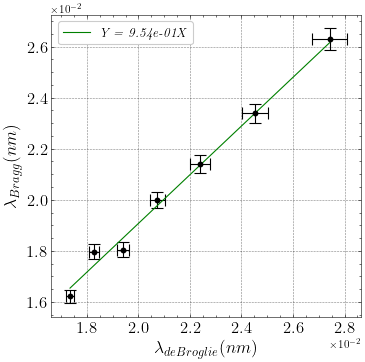

In [59]:
# FITTING THE DATA USING A LINEAR RELATIONSHIP ---------------------------------------
xdata, ydata = df['$\lambda_{de Broglie} (nm)$'], df['$\lambda_{Bragg} (nm)$']
error_x, error_y = df['$\Delta \lambda_{de Broglie} (nm)$'], df['$\Delta \lambda_{Bragg} (nm)$']
# LINEAR REGRESSION USSING UNCERTAINTY IN X AND Y
from scipy.odr import ODR, Model, Data, RealData
model = Model(linearODR)

data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0,0])
odr.set_job(fit_type=2)
output = odr.run()
a,b = output.beta[0], output.beta[1]

#Calculate the error on the fits from the std matrix
slope = output.beta[0]
slope_error = output.sd_beta[0]
LinearPlotODR(xdata,ydata,error_y,error_x,a,b,linearODR,output,'green','$\lambda_{de Broglie} (nm)$','$\lambda_{Bragg} (nm)$')
print('Slope = ', slope, ' ± ', slope_error)
error = abs(1-slope)*100
print('Error = ', error, '%')

In [60]:
# CALCULATING WAVELENGTHS USING BRAGG CONDITION FOR: Larger ring (Middle)
df['$\lambda_{Bragg} (nm)$'] = df[['D_avg4']].apply(lambda x: lambda_bragg([x[0],L,d11]),axis=1)
df['$\Delta \lambda_{Bragg} (nm)$'] = df[['D_prime4','Delta_prime4']].apply(lambda x: uncertainty_var([x[0],L,d11],[x[1],L_error,0],lambda_bragg),axis=1)
df

,V (kV),Delta V (kV),D_avg1,D_avg2,D_avg3,D_avg4,Delta D,D_prime1,D_prime2,D_prime3,D_prime4,Delta_prime1,Delta_prime2,Delta_prime3,Delta_prime4,$\lambda_{de Broglie} (nm)$,$\Delta \lambda_{de Broglie} (nm)$,$\lambda_{Bragg} (nm)$,$\Delta \lambda_{Bragg} (nm)$
0,2.0,0.1,0.030610,0.031860,0.055560,0.057305,0.00005,0.031407,0.032729,0.059025,0.061085,0.000053,0.000053,0.000059,0.000059,0.027424,0.000687,0.027110,0.000446
1,2.5,0.1,0.027205,0.029850,0.049425,0.051820,0.00005,0.027829,0.030606,0.051943,0.054680,0.000052,0.000053,0.000057,0.000057,0.024529,0.000491,0.024515,0.000399
2,3.0,0.1,0.024045,0.026860,0.045230,0.046935,0.00005,0.024537,0.027469,0.047226,0.049132,0.000052,0.000052,0.000056,0.000056,0.022391,0.000373,0.022204,0.000359
3,3.5,0.1,0.022635,0.026015,0.042240,0.044050,0.00005,0.023075,0.026587,0.043919,0.045916,0.000052,0.000052,0.000055,0.000055,0.020730,0.000296,0.020839,0.000335
4,4.0,0.1,0.021065,0.023345,0.038135,0.040660,0.00005,0.021452,0.023810,0.039444,0.042188,0.000052,0.000052,0.000054,0.000055,0.019391,0.000242,0.019235,0.000308
5,4.5,0.1,0.019545,0.021755,0.037990,0.038770,0.00005,0.019886,0.022165,0.039287,0.040132,0.000051,0.000052,0.000054,0.000054,0.018282,0.000203,0.018341,0.000293
6,5.0,0.1,0.018845,0.020025,0.034290,0.036605,0.00005,0.019166,0.020380,0.035313,0.037794,0.000051,0.000051,0.000053,0.000054,0.017344,0.000173,0.017317,0.000276


Slope =  0.996908530928011  ±  0.0023852741785168195
Error =  0.30914690719889837 %


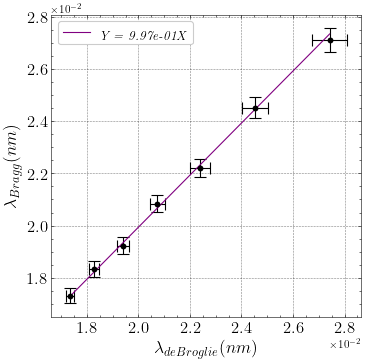

In [61]:
# FITTING THE DATA USING A LINEAR RELATIONSHIP ---------------------------------------
xdata, ydata = df['$\lambda_{de Broglie} (nm)$'], df['$\lambda_{Bragg} (nm)$']
error_x, error_y = df['$\Delta \lambda_{de Broglie} (nm)$'], df['$\Delta \lambda_{Bragg} (nm)$']
# LINEAR REGRESSION USSING UNCERTAINTY IN X AND Y
from scipy.odr import ODR, Model, Data, RealData
model = Model(linearODR)

data = RealData(xdata, ydata, error_x, error_y)
odr = ODR(data, model, [0,0])
odr.set_job(fit_type=2)
output = odr.run()
a,b = output.beta[0], output.beta[1]

#Calculate the error on the fits from the std matrix
slope = output.beta[0]
slope_error = output.sd_beta[0]
LinearPlotODR(xdata,ydata,error_y,error_x,a,b,linearODR,output,'purple','$\lambda_{de Broglie} (nm)$','$\lambda_{Bragg} (nm)$')
print('Slope = ', slope, ' ± ', slope_error)
error = abs(1-slope)*100
print('Error = ', error, '%')